# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 8:  CNNs, Autoencoders, and Transfer Learning

**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young<br/>
<br/>

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /Harvard-IACS/2019-CS109B/master/content/styles/cs109.css (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f5a433b4550>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

<a id="contents"></a>

## Notebook Contents
- [**Using SEAS Jupyter Hub**](#jubyterhub)
- [**Keras for CNNs**](#keras)
    - [Layers of a CNN in Keras](#keras_layers)
- [**Revisiting KMNIST**](#kmnist)
    - [Baseline CNN Classifier](#baseline)
    - [**Exercise:** Improving on Baseline Model](#improving)
- [**Tensorflow Datasets**](#tfdatasets)
    - [Loading Datasets](#loadds)
    - [The Dataset Object](#dsobj)
    - [Take, Cardinality, & Batch](#take)
    - [Cache, Prefetch, & Shuffle](#cache)
    - [Preprocessing with Datasets](#dspreproc)
    - [Data Augmentation](#dataaug)
- [**Transfer Learning**](#transfer_learning)
    - [MobileNet](#mobilenet)

    

<a id='jupyterhub'></a>
## Using SEAS JupyterHub-GPU [^](#contents "Back to Contents")


<img src='fig/need-a-gpu.jpg' width='250px'>

SEAS and FAS are providing you with a Jupyter computing environment to use for your CS109B course work. It is accessible from 'JupyterHub' in the menu on the Canvas course page. The **GPU** available on these instances allow for much faster NN training. The libraries defined in your cs109b.yml (keras, tensorflow, pandas, etc.) are all pre-installed.

**NOTE : This service funded by SEAS and FAS for the purposes of the class.**

**NOTE NOTE NOTE: You are only to use JupyterHub-GPU for purposes directly related to CS109B coursework.**

**Help us keep this service: Make sure you stop your instance as soon as you do not need it.**

In [0]:
# Check if GPU is available and visible to TensorFlow
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

<a id='keras'></a>
## Keras [^](#contents "Back to Contents")
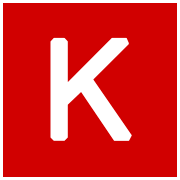

From our work in the previous sections of this notebook I'm sure you can now appreciate that implementing a non-trivial CNN by hand would be a pain, and the looping code above was far from optimized. So we will be using <a href='https://keras.io/'>Keras</a> to quickly construct our neural networks.

The Keras API that sits on top of Tensorflow. It allows user to work at a more intuitive level of abstraction where the basic objects are **layers**.

<div id="keras_layers" class='exercise'><b>Layers of a CNN in Keras</b></div></br>
<img src='fig/cnn1.png' width='900px'>

The following is a list of layers commonly used when building CNNs with Keras.<br>
A link to the official documentation for each layer is also provided.

### Input

[**tf.keras.Input**](https://www.tensorflow.org/api_docs/python/tf/keras/Input)(
    shape=None, **kwargs
)

<div style='color:red'><strong>The input is not a layer!</strong></div>

As Pavlos said in lecture, you shouldn't think of the input to your network as a layer. Unfortunately, in Keras, most components of a network are referred to as 'layers'. Someone must have come to their senses because now `Input` can be found in the base `tf.keras` module. While it *can* still be imported from `tf.keras.layers`, we are civilized people and shall speak no more of that.

The network will be expecting input of fixed shape which must be specified with the `shape` parameter. You should look at the data you are using to determine this shape.

Adding an explicit `Input` object to your layer is not required as most layers have an `input_shape` that can be specified if they are the first layer in the network.



### 2D Convolutional Layers

[**keras.layers.Conv2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', data_format='channels_last', 
                    bias_initializer='zeros')

<img src='fig/conv-many-filters.png' width='550px'>

**Some quick review if skipping to this section:**

A convolutional layer is composed of **filters**, which are composed of **kernels** which are themselves composed of **weights**. Each filter also has a bias term though it is often not depicted in diagrams (it is exluded in the one above for example). We learn the weights and biases from our data. Each conv layer also has an associated **activation function** such as ReLU or sigmoid. 

The **number of filters** and the **height and width of the kernels** of which they consist are set by the `filters` and `kernel_size` (a tuple) arguments respectively. 

The **depth of the filters is fixed** by the depth (i.e., 'channels' or 'filter maps') of the input to the conv layer. 

The output of the conv layer is is a 3D tensor which is a set of **feature maps**. Each feature map is itself the output of one of the layer's filters convolving on the input. The height and width of the feature map tensor is determined by the input size, `kernel_size`, `padding`, and `stride`. The depth of the output tensor (i.e, number of feature maps) is equal to the number of filters in the layer.
                    
Keras also has a [1D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) used for time series data and a [3D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) used for video.

### Pooling Layers

[**keras.layers.MaxPool2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

<img src='fig/maxpool.png' alt='MaxPool' width='400px'>

Pooling layers are also comprised of filters and feature maps. Let's say the pooling layer has a 2x2 receptive field and a stride of 2. This stride results in feature maps that are one half the size of the input feature maps. We can use a max() operation for each receptive field. 

### Dropout Layers
<img src='fig/dropout.gif' width='200px'>

[**tf.keras.layers.Dropout**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)(rate, seed=None)

Dropout consists in randomly setting a fraction of input units to 0 at each update during training time. In Keras this fraction is set by the `rate` parameter. At inference time, trained weights are multipled by $(1 - \text{rate})$. Dropout often used to help prevent overfitting by limiting the complexity of our model. It can also prevent groups of neurons from 'conspiring' together to have a large affect on the out put, something traditional forms of weight regularization would not catch.

**Caution:** Dropout's behavior is not the same if performed after a convolutional layer! [See this post for more information](https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2).

**Q:** Why might it make sense to think of dropout as a type of ensemble method? 🤔

References<br>
[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

### Flatten Layers


[**keras.layers.Flatten**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)()

Like `Input` and `Dropout`, `Flatten` is not a layer in the traditional sense. It has no learned parameters and no parameters other than `input_shape`. Its only function is to flatten its multi-dimensional input into a flat vector. The flatten layer sits between our final 2D output (either from Conv2D or MaxPool2D) and our first fully connected, `Dense` layer.


### Global Average Pooling Layers

[**keras.layers.GlobalAveragePooling2D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)()

The GlobalAveragePooling2D layer is a type of pooling layer that is commonly used in convolutional neural networks (CNNs), particularly towards the end of the network, before the final classification layers as an alternative to `Flatten`.

**What is Global Average Pooling (GAP)?**

Global Average Pooling (GAP) is an operation that calculates the average value of each feature map in the previous layer. Unlike traditional pooling layers that operate on local regions (e.g., 2x2 pools), GAP processes the entire feature map. For a given feature map, GAP outputs a single average value, effectively reducing the spatial dimensions (width and height) of the feature map to 1. If a convolutional layer outputs H x W x C feature maps (H being height, W width, and C channels or depth), applying GAP will reduce this to 1 x 1 x C, transforming spatial features into a flat vector.

**Why Use Global Average Pooling?**

- **Reduces Overfitting:** By summarizing the spatial information, GAP reduces the total number of parameters in the model. This simplification can help prevent overfitting, as there are fewer parameters to learn compared to when using fully connected layers directly after convolutional layers.

- **Seamless Transition to Classification:** By outputting a flat vector that corresponds to the number of feature maps, GAP provides an efficient way to transition from convolutional layers (which are good at extracting spatial features) to dense layers (used for classification). The output of GAP can be directly fed into a dense layer without the need for reshaping or flattening.

### Fully Connected Layers.

[**keras.layers.Dense**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)(units, activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros')
                    
<img src='fig/dense.png' width='250px'>

Most CNNs have of one or more dense layers at the end with the final layer referred to as the **output layer**. You'll need to specify the number of `units` in each layer (sometimes called 'neurons' or 'nodes') as well as the `activation`. 

*Special care should be taken in deciding on the activation function for the output layer!* The correct choice of activation in this final layer depends on the task we are training our model to perform. For example, a linear activation for regression, but a sigmoid for binary classification.



<a id='kmnist'></a>
## Revisting KMNIST [^](#contents "Back to Contents")

Let's try to put some of our new tools to work by building a CNN classifer for the KMNIST dataset from HW3.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [0]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [0]:
# your code here
X_kmnist_train = pd.read_csv("kmnist/kmnist_train.csv.zip").drop(columns="output").values
y_kmnist_train = pd.read_csv("kmnist/kmnist_train.csv.zip")["output"].values

X_kmnist_test = pd.read_csv("kmnist/kmnist_test.csv.zip").values

# reshape both X frames for proper pixel representation in imshow plots
X_kmnist_train = X_kmnist_train.reshape(-1, 28, 28, 1)/255.
X_kmnist_test = X_kmnist_test.reshape(-1, 28, 28, 1)/255.

print(
    "The shapes of the Kannada MNIST X and y datasets are:\n\n"
    "\tX train\t{}\n\ty train\t{}\n\n\tX TEST\t{}".format(
        X_kmnist_train.shape, y_kmnist_train.shape, X_kmnist_test.shape
    )
)

Let's just remind ourselves what the dataset looks like.

In [0]:
idx_list = [2, 1]

fig, axes = plt.subplots(1,2, figsize=(6,3.5))

plt.suptitle(
    "Sample KMNIST training characters",
    y=1,
    fontsize=18,
)

for idx, ax in zip(idx_list, axes.flat):
    ax.imshow(X_kmnist_train[idx], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(
        "class label: {}".format(y_kmnist_train[idx]),
        fontsize=14,
    )

plt.tight_layout();

In [0]:
X_kmnist_train.shape, X_kmnist_test.shape

In [0]:
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GaussianNoise
from keras.layers import GlobalAveragePooling2D, Input, MaxPool2D, RandomRotation, UpSampling2D
from keras.models import Model, Sequential
from keras import losses
from keras import optimizers
from keras import layers
from keras import callbacks

<div id="baseline" class='exercise'><b>Baseline Classifer</b></div></br>

In [0]:
inp = Input(shape=(28,28,1))
x = Conv2D(64, 2, activation='relu', padding='same')(inp)
x = MaxPool2D(2)(x)
x = Conv2D(32, 2, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Conv2D(16, 2, activation='relu', padding='same')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

baseline = Model(inputs=[inp], outputs=out)
baseline.summary()

In [0]:
# import tensorflow as tf
# tf.data.experimental.enable_debug_mode()

In [0]:
baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [0]:
baseline.fit(X_kmnist_train,
             y_kmnist_train,
             validation_split=.2,
             batch_size=64,
             callbacks=es,
             epochs=50)

In [0]:
def plot_hist(model, title=None):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(model.history.history['loss'], label='train')
    axs[0].plot(model.history.history['val_loss'], label='val')
    axs[0].axvline(np.argmin(model.history.history['val_loss']), c='k', ls=':', label='final model')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('BCE Loss')
    axs[0].legend()
    axs[1].plot(model.history.history['accuracy'], label='train')
    axs[1].plot(model.history.history['val_accuracy'], label='val')
    axs[1].axvline(np.argmin(model.history.history['val_loss']), c='k', ls=':', label='final model')
    axs[1].legend();
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)

In [0]:
plot_hist(baseline, 'Baseline KMNIST Classifier')

In [0]:
y_kmnist_test = pd.read_csv('kmnist/solution_kaggle.csv')['category'].values

baseline.evaluate(X_kmnist_test, y_kmnist_test)

<div id="improving" class='exercise'><b>Improving on the Baseline</b></div></br>

In [0]:
# your code here


<a id='tfdatasets'></a>

## Tensorflow Datasets [^](#contents "Back to Contents")
<img src='https://3.bp.blogspot.com/-d-nV7xJRmpw/Xo328dcAx3I/AAAAAAAAC7Q/qlqJOle6XIosJ3CGIDJ04F3Voh1iXDg0gCLcBGAsYHQ/s1600/TF_FullColor_Icon.jpg' width='150'>

TensorFlow Datasets (TFDS) is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks. These datasets are exposed as `tf.data.Dataset` objects, enabling easy-to-use and high-performance input pipelines.

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [0]:
# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

<div id="loadds" class='exercise'><b>Loading Datasets</b></div></br>

TFDS gives us access to dozens of research quality datasets with the simple `tfds.load` method.<br>
An extensive catalogue of datasets can be seen <a href='https://www.tensorflow.org/datasets/catalog/overview'>here</a>. You can even <a href='https://www.tensorflow.org/datasets/add_dataset'>write your own custom dataset</a>.

### <div style='font-size: 150%'>🐎 or 🧍?</div>

But it doesn't mean you should just because you can. The *bizzare* <a href='http://laurencemoroney.com/horses-or-humans-dataset'>Horses or Humans</a> dataset may just be an example of this.<br>
Our call to `tfds.load` will use several arguments:
- `name`: (str) the dataset to load (you can look these up in the above catalogue)
- `split`: (list) some datasets have pre-specified splits; this list defines which splits to load
- `shuffle_files`: (bool) files are loaded in random order
- `as_supervised`: (bool) loads labels if dataset has them
- `with_info`: (bool) also returns an DatasetInfo object with details about the loaded dataset


In [0]:
tfds.disable_progress_bar()

In [0]:
(ds_train, ds_test), ds_info = tfds.load(name="horses_or_humans", split=['train', 'test'],
                                         shuffle_files=True, as_supervised=True, with_info=True, )

The `ds_info` we got from using `with_info=True` gives us a great overview of some facts about the dataset.

In [0]:
ds_info

<div id="dsobj" class='exercise'><b>The Dataset Object</b></div></br>

We'll be working with closely with the `tf.data.Dataset` object so we should learn more about its methods and structure.

**Some Python Arcana: Iterables & Iterators**:<br>

The `tf.data.Dataset` object is an *iterable*, which means it implements an `__iter__` method which returns an *iterator* object.<br>
An *iterator* is an object that implements a `__next__` method which returns the next element in the iterator!

In [0]:
# create iterator from iterable
my_iter = iter(ds_train)
my_iter

In [0]:
# get next element from iterator
next_one = next(my_iter)
print(f'Each element in the iterator is of type {type(next_one)} with length {len(next_one)}')

In [0]:
# display element from iterator
next_one

Inspecting this tuple we see the 1st element is our image and the 2nd is the lable. Let's visualize the image.

In [0]:
image, label = next_one
plt.imshow(image)
plt.title(int(label));

It appears humans are the positive class. Let's make a dictionary to map class labels to strings.

In [0]:
# create human interperatable class names
class_names = {0: 'horse', 1: 'human'}

**Iterating**

Iterables can be looped over with a `for` loop. And while you *can* loop over the `Dataset` iterable object itself it is more common to first use the `as_numpy_iterator()` method if running TF in eager mode.

In [0]:
rows = 3
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(10,6))
for ax, (img, label) in zip(ax.ravel(), ds_train.as_numpy_iterator()):
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(img)
    ax.set_title(class_names[label])
    ax.axis('off')

The above method works, but it would be a nuisance to have to always write out all that code just to inspect our datasets.

Luckily, `tfds` has a much faster way to do this with the `show_examples()` method.

In [0]:
# train examples
tfds.show_examples(ds_train, ds_info, rows=rows, cols=cols);

In [0]:
# test examples
tfds.show_examples(ds_test, ds_info, rows=rows, cols=cols);

**Q:** Do you notice anything strange about the test examples? 🤔

<div id="take" class='exercise'><b>Take, Cardinality, & Batch</b></div></br>

**Take**

We can use the `take()` method to return a **subset** of the original `Dataset` object of a desired **cardinality**.

In [0]:
# get a subset with cardinality 2
my_subset = ds_train.take(2)

**Cardinality**

It's true that we can check the length of a datset with `len()`

In [0]:
# one way to find a Dataset's length
len(my_subset)

But this is inefficient  for larger datasets.<br>
It is preferable to use the `cardinality()` method. This returns a Tensor.

In [0]:
# a better way
cardinality = my_subset.cardinality()
print(f'Cardinality Type: {type(cardinality)}')

It looks a bit strange when displayed.

In [0]:
# displaying an EagerTensor
cardinality

But it behaves just like an integer.

In [0]:
# no surprises here!
(cardinality + 2) == 4

And if you really want to, you can always convert it to a `numpy.int64` object which prints nicely.

In [0]:
# convert to nump.int64
cardinality.numpy()

**Batch**

To get the benefits of <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>**stochastic gradient descent**</a> (SGD) during training, we'd like to feed elements from the dataset into our model in batches.<br>
This is handled by the `batch()` method.

**Q:** What are some benefits of SGD? 🤔

In [0]:
BATCH_SIZE = 32
num_batch = ds_train.cardinality() / BATCH_SIZE
print(f'Number of Potential Batches of size {BATCH_SIZE}:', num_batch.numpy())
num_batched_produced = ds_train.batch(BATCH_SIZE).cardinality()
print(f'Number of Batches of size {BATCH_SIZE} Produced:', num_batched_produced.numpy())

**Q:** Why don't these numbers match? What's going on? 🤔

The batched dataset is itself a `Dataset`, but now it's an iterable that produces batches.<br>
In a **supervised** situation like ours, each batch is a tuple.

In [0]:
# inspect first batch
my_batch = ds_train.batch(BATCH_SIZE).as_numpy_iterator().next()
print(f'Each batch is of type {type(my_batch)} with length {len(my_batch)}')

The 1st element of the tuple are all the images in the batch.

In [0]:
# batch images
my_batch[0].shape

The 2nd element are all the labels in the batch.

In [0]:
# batch labels
my_batch[1].shape

**Note:** The batch of images and labels above are both `numpy` arrays. This is because we used `as_numpy_iterator()` on our batched dataset. This is why we were able to use the `shape` attribute. here.

We can also strengthen our intuition about the structure of the batched dataset by iterating over the batches and displaying the first image in each.

In [0]:
# display the first image in each batch
fig, axs = plt.subplots(4, 8, figsize=(9,5))
axs = axs.ravel()
for i, (img_batch, label_batch) in enumerate(ds_train.batch(BATCH_SIZE, drop_remainder=True)):
    for (img, label) in zip(img_batch, label_batch):
        axs[i].imshow(img)
        axs[i].set_title(f'batch {i+1}')
        axs[i].axis('off')
        break
plt.tight_layout()

<div id="cache" class='exercise'><b>Cache, Prefetch & Shuffle</b></div></br>

There are helpful methods we can use to optimize the training process. Most of these descriptions are adapted from the TensorFlow documentation. As always, the documentation is the best place to go if you'd like a deeper understanding.

**<a href="https://www.tensorflow.org/guide/data_performance#caching">`Cache`</a>** caches a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. (perhaps not a good idea for enormous datasets)

**`Prefetching`** overlaps the preprocessing and model execution of a training step. While the model is executing training steps, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data."

**<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle">`Shuffle`</a>** Randomly shuffles the elements of this dataset.

**Note:** cache will produce exactly the same elements during each iteration through the dataset. If you wish to randomize the iteration order, make sure to call shuffle after calling cache.

And of course we can chain all these commands together!

In [0]:
images, labels = ds_train.cache()\
                         .shuffle(buffer_size=ds_train.cardinality(), seed=SEED, reshuffle_each_iteration=True)\
                         .batch(BATCH_SIZE).prefetch(AUTOTUNE)\
                         .as_numpy_iterator().next() # one batch
# show first image in batch
plt.imshow(images[0])
plt.title(class_names[labels[0]])
plt.axis('off');

<div id="dspreproc" class='exercise'><b>Preprocessing with Datasets</b></div></br>

Often, we'll want to **preprocess** our data in some way before feeding it into our model.<br>
We can use use the `Dataset` object's `map` method to perform arbitrary functions on the elements of the dataset.

Because the result of the `map` operation is itself a dataset object, we can continue to chain these commands one after another.<br>
Here we are normalizing and resizing our images as part of the preprocessing stage using functions of our own design. 

In [0]:
H = W = 224

def normalize_img(img, label):
    return tf.cast(img, tf.float32)/255.0, label

def resize_img(img, label):
    return tf.image.resize(img, size=[H, W]), label

def preprocess(img, label):
    img, label = normalize_img(img, label)
    img, label = resize_img(img, label)
    return img, label

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)

<div id="dataaug" class='exercise'><b>Data Augmentation</b></div></br>


We almost always wish we had *more data*! But it can be expensive and time consuming to gather and label new data.<br>
So why not **simulate new data?** We can accomplish this by creating variants of our original data. 

In the case of images this is very intuitive. Simply rotate your picture of a horse. It's still a horse, but the rotated image is likely different from anything in your data original. As long as the simulated data is not *too* different from the sort of example's we'd like to learn, this can help our model generalize better to previously unseen examples not in the original dataset.

In [0]:
import tensorflow_addons as tfa

def random_rotate(image, label):
    """Dataset pipe that rotates an image, helper function to augment below"""
    shape = image.shape
    deg = tf.random.uniform([],-10.,10.)
    image = tfa.image.rotate(image, deg/180.*np.pi, interpolation="BILINEAR")
    image.set_shape((shape))
    label.set_shape(())
    return image, label

def random_zoom(image, label):
    """Dataset pipe that zooms an image, helper function to augment below"""
    rand_float = tf.random.uniform([],10,20)
    rand_int = tf.cast(rand_float, tf.int32)
    image = tf.image.resize_with_crop_or_pad(image,
                                             H + H//rand_int,
                                             W + W//rand_int)
    image = tf.image.random_crop(image, size=[H, W, 3])
    return image, label
    
def augment(image, label):
    """Function that randomly alters an image with
       flipping, rotation, zoom, and contrast adjustment"""
    image = tf.image.random_flip_left_right(image)
    image, label = random_rotate(image, label)
    # image, label = random_zoom(image, label)
    # image = tf.image.random_contrast(image, lower=.95, upper=1.)
    
    return image, label

Here are just a few examples created using the augmentation functions defined above!

In [0]:
# display a batch of altered images
fig, axs = plt.subplots(4,4, figsize=(6,6))
aug_batch = ds_train.map(augment, num_parallel_calls=AUTOTUNE).take(16)
for ax, (img, label) in zip(axs.ravel(), aug_batch):
    ax.imshow(img)
    ax.axis('off')

Data augmentation is an important topic and it will be revisited several times throughout the course!

<div id="val_split" class='exercise'><b>Creating a Validation Set</b></div></br>

We can see from `ds_info` above that this dataset had predefined train and test sets. We loaded both.

Some TF datasets also have a validation set. Others have only train. We'd like to use a validation set while training our model. And in situations where your data set only has a train set it will be important to know how to create new splits. As of Tensorflow 2.10 this is made easy with the `tf.keras.utils.split_dataset()` methods which works similar to the train_test_split in SKLearn.

In [0]:
left_ds, right_ds = keras.utils.split_dataset(ds_train, left_size=0.8)

In [0]:
left_ds.cardinality() + right_ds.cardinality() == ds_train.cardinality()

<a id='transfer_learning'></a>
## Transfer Learning [^](#contents "Back to Contents")

Here we can see an example of transfer learning where we use the pretrained MobileNet model as the base of our classifier.

<div id="mobilenet" class='exercise'><b>MobileNet</b></div></br>

In [0]:
ds_train, ds_info = tfds.load('horses_or_humans', split='train', as_supervised=True, with_info=True)
ds_test = tfds.load('horses_or_humans', split='test', as_supervised=True)
ds_train, ds_val = keras.utils.split_dataset(ds_train, left_size=0.8)

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

ds_train = ds_train.map(preprocess).map(augment).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')

# Freeze the base model's layers to prevent them from being updated during training
base_model.trainable = False

# Add custom layers on top of MobileNet
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = keras.layers.Dense(1024, activation='relu')(x)
# Add a logistic layer for binary classification
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=10)

In [0]:
model.evaluate(ds_test)